# Análise: Gravidade de Acidentes vs Volume de Tráfego em NYC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configurações de visualização
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [3]:
# Carregar dados de acidentes
accidents = pd.read_csv("US_Accidents.csv", parse_dates=["Start_Time"])

# Filtrar apenas NYC
nyc_accidents = accidents[
    (accidents["State"] == "NY") & 
    (accidents["City"] == "New York")
].copy()

# Selecionar colunas relevantes
nyc_accidents = nyc_accidents[[
    "ID", "Severity", "Start_Time", "Start_Lat", "Start_Lng", "Street"
]]

# Converter Start_Time manualmente com segurança
nyc_accidents["Start_Time"] = pd.to_datetime(nyc_accidents["Start_Time"], errors="coerce")

# Remover valores nulos (inválidos)
nyc_accidents = nyc_accidents.dropna(subset=["Start_Time"])

# Extrair data e hora
nyc_accidents["Date"] = nyc_accidents["Start_Time"].dt.date
nyc_accidents["Hour"] = nyc_accidents["Start_Time"].dt.hour

print(f"Acidentes em NYC: {len(nyc_accidents)} registros")
nyc_accidents.head()


Acidentes em NYC: 18883 registros


ID  Severity          Start_Time  Start_Lat  Start_Lng  \
194401  A-194408         2 2016-12-01 08:21:11  40.770107 -73.957397   
194415  A-194422         3 2016-12-01 08:49:35  40.849579 -73.942314   
194468  A-194475         2 2016-12-01 12:08:26  40.748028 -73.968170   
194533  A-194540         2 2016-12-02 05:19:11  40.761723 -73.982803   
194551  A-194558         2 2016-12-02 07:09:04  40.782818 -73.943871   

                       Street        Date  Hour  
194401              E 74th St  2016-12-01     8  
194415  George Washington Brg  2016-12-01     8  
194468               FDR Dr S  2016-12-01    12  
194533                7th Ave  2016-12-02     5  
194551              E 96th St  2016-12-02     7

In [4]:
# Carregar dados de tráfego
traffic = pd.read_csv("nyc_traffic_volume.csv")

# Criar campo de datetime
traffic["datetime"] = pd.to_datetime(
    traffic["Yr"].astype(str) + "-" + 
    traffic["M"].astype(str) + "-" + 
    traffic["D"].astype(str) + " " + 
    traffic["HH"].astype(str) + ":" + 
    traffic["MM"].astype(str)
)

# Selecionar colunas relevantes
traffic = traffic[["datetime", "Vol", "street", "Boro"]]

# Padronizar nomes de ruas (remover espaços e caracteres especiais)
traffic["street_clean"] = (
    traffic["street"]
    .str.lower()
    .str.replace("[^a-z0-9]", "", regex=True)
)

print(f"Registros de tráfego: {len(traffic)}")
traffic.head()


Registros de tráfego: 27190511


datetime  Vol              street           Boro  \
0 2015-06-23 23:30:00    9           94 AVENUE         Queens   
1 2015-09-14 04:15:00    6    RICHMOND TERRACE  Staten Island   
2 2017-10-19 04:30:00   85  HUNTS POINT AVENUE          Bronx   
3 2017-11-07 18:30:00  168     FLATBUSH AVENUE       Brooklyn   
4 2017-11-03 22:00:00  355   WASHINGTON BRIDGE      Manhattan   

       street_clean  
0          94avenue  
1   richmondterrace  
2  huntspointavenue  
3    flatbushavenue  
4  washingtonbridge

In [5]:
# Padronizar nomes de ruas nos acidentes
nyc_accidents["street_clean"] = (
    nyc_accidents["Street"]
    .str.lower()
    .str.replace("[^a-z0-9]", "", regex=True)
)


In [9]:
# Criar janela temporal (1 hora antes/depois)
merged_data = pd.merge_asof(
    nyc_accidents.sort_values("Start_Time"),
    traffic.sort_values("datetime"),
    left_on="Start_Time",
    right_on="datetime",
    left_by="street_clean",
    right_by="street_clean",
    direction="nearest",
    tolerance=pd.Timedelta("1h")
)

print(f"Dados integrados: {len(merged_data)} registros")
merged_data.head(10000)


Dados integrados: 18883 registros


ID  Severity          Start_Time  Start_Lat  Start_Lng  \
0     A-3516392         2 2016-03-24 09:56:12  40.838860 -73.933200   
1     A-3516418         3 2016-03-24 15:23:08  40.848097 -73.935385   
2     A-3516421         3 2016-03-24 15:45:40  40.772694 -73.944951   
3     A-3516431         2 2016-03-24 17:24:50  40.805150 -73.932020   
4     A-3516434         2 2016-03-24 17:40:16  40.709690 -74.001510   
...         ...       ...                 ...        ...        ...   
9995  A-6801811         2 2020-12-22 15:02:52  40.848079 -73.936259   
9996  A-6975008         2 2020-12-22 15:02:52  40.848079 -73.936259   
9997  A-1218379         3 2020-12-22 15:27:59  40.847923 -73.942825   
9998  A-1218386         2 2020-12-22 17:25:29  40.758682 -73.958748   
9999  A-1218395         2 2020-12-22 17:52:53  40.758682 -73.958748   

                        Street        Date  Hour          street_clean  \
0            Harlem River Dr S  2016-03-24     9        harlemriverdrs   
1       Trans-Manhattan Expy W  2016-03-24    15   transmanhattanexpyw   
2                     FDR Dr N  2016-03-24    15                fdrdrn   
3            Harlem River Dr S  2016-03-24    17        harlemriverdrs   
4                     Pearl St  2016-03-24    17               pearlst   
...                        ...         ...   ...                   ...   
9995                    I-95 N  2020-12-22    15                  i95n   
9996                    I-95 N  2020-12-22    15                  i95n   
9997              Riverside Dr  2020-12-22    15           riversidedr   
9998  Ed Koch Queensboro Brg E  2020-12-22    17  edkochqueensborobrge   
9999  Ed Koch Queensboro Brg E  2020-12-22    17  edkochqueensborobrge   

     datetime  Vol street Boro  
0         NaT  NaN    NaN  NaN  
1         NaT  NaN    NaN  NaN  
2         NaT  NaN    NaN  NaN  
3         NaT  NaN    NaN  NaN  
4         NaT  NaN    NaN  NaN  
...       ...  ...    ...  ...  
9995      NaT  NaN    NaN  NaN  
9996      NaT  NaN    NaN  NaN  
9997      NaT  NaN    NaN  NaN  
9998      NaT  NaN    NaN  NaN  
9999      NaT  NaN    NaN  NaN  

[10000 rows x 13 columns]

In [13]:
# Verificar em todo o DataFrame
if merged_data['Boro'].isna().any():
    print(f"Total de valores NaN em 'Vol': {merged_data['Boro'].isna().sum()}")
else:
    print("Nenhum valor NaN em 'Vol' em todo o DataFrame")

Total de valores NaN em 'Vol': 18869


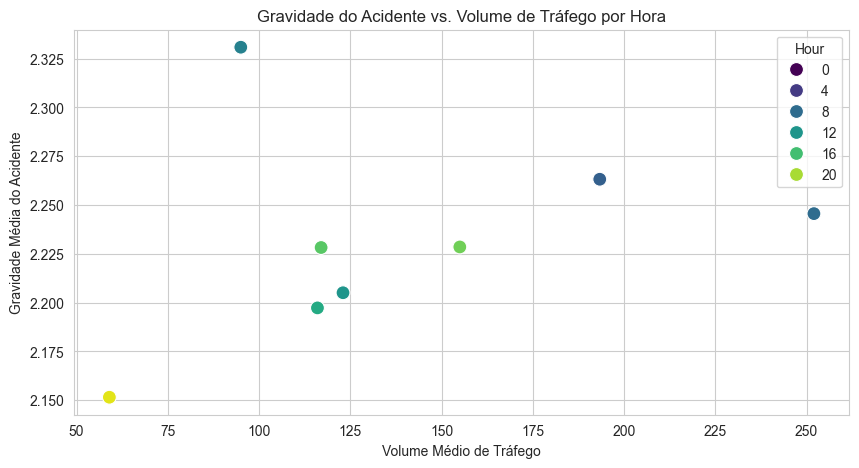

In [7]:
# Agrupar por hora e calcular médias
hourly_stats = merged_data.groupby("Hour").agg({
    "Severity": "mean",
    "Vol": "mean"
}).reset_index()

# Plotar correlação
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=hourly_stats,
    x="Vol",
    y="Severity",
    hue="Hour",
    palette="viridis",
    s=100
)
plt.title("Gravidade do Acidente vs. Volume de Tráfego por Hora")
plt.xlabel("Volume Médio de Tráfego")
plt.ylabel("Gravidade Média do Acidente")
plt.show()
